In [1]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:
import pandas as pd

# Chemin du fichier Excel
file_path = "C:\\Users\\MM_DATA\\Desktop\\PIST\\Prediction\\Etat_des_sorties_final.xlsx"

# Lecture du fichier Excel
data = pd.read_excel(file_path)

# Affichage des premières lignes pour vérification
print(data.head())


   N° B.C  N° B.L                                  MARKETER  N° B.E.C  \
0    8943    8355  TOTALENERGIES MARKETING TOGO              30427577   
1    8944    8356  TOTALENERGIES MARKETING TOGO              30427578   
2    8945    8357  TOTALENERGIES MARKETING TOGO              30427578   
3    8946    8358  TOTALENERGIES MARKETING TOGO              30427579   
4    8947    8359  TOTALENERGIES MARKETING TOGO              30427580   

                               DESTINATAIRE  \
0  TOTALENERGIES HIHEATRO                     
1  TOTALENERGIES TEMEDJA                      
2  TOTALENERGIES TEMEDJA                      
3  FAT 3E RI-TEMEDJA                          
4  TOTALENERGIES ANIE 1                       

                                    PRODUIT       DATE  \
0  SUPER                                    2019-01-03   
1  SUPER                                    2019-01-03   
2  GASOIL                                   2019-01-03   
3  GASOIL                                   20

## Prétraitement et visualisation

In [3]:
# Prétraitement des données

# Gestion des valeurs manquantes
data.dropna(inplace=True)

# Conversion du format de date en datetime
data['DATE'] = pd.to_datetime(data['DATE'])

# Affichage des informations sur les données après prétraitement
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301392 entries, 0 to 301391
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   N° B.C        301392 non-null  int64         
 1   N° B.L        301392 non-null  int64         
 2   MARKETER      301392 non-null  object        
 3   N° B.E.C      301392 non-null  object        
 4   DESTINATAIRE  301392 non-null  object        
 5   PRODUIT       301392 non-null  object        
 6   DATE          301392 non-null  datetime64[ns]
 7   TRANSPORTEUR  301392 non-null  object        
 8   TRACTEUR      301392 non-null  object        
 9   CITERNE       301392 non-null  object        
 10  ZONE          301392 non-null  object        
 11  TYPE DOUANE   301392 non-null  object        
 12  VOLUME        301392 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(9)
memory usage: 29.9+ MB
None


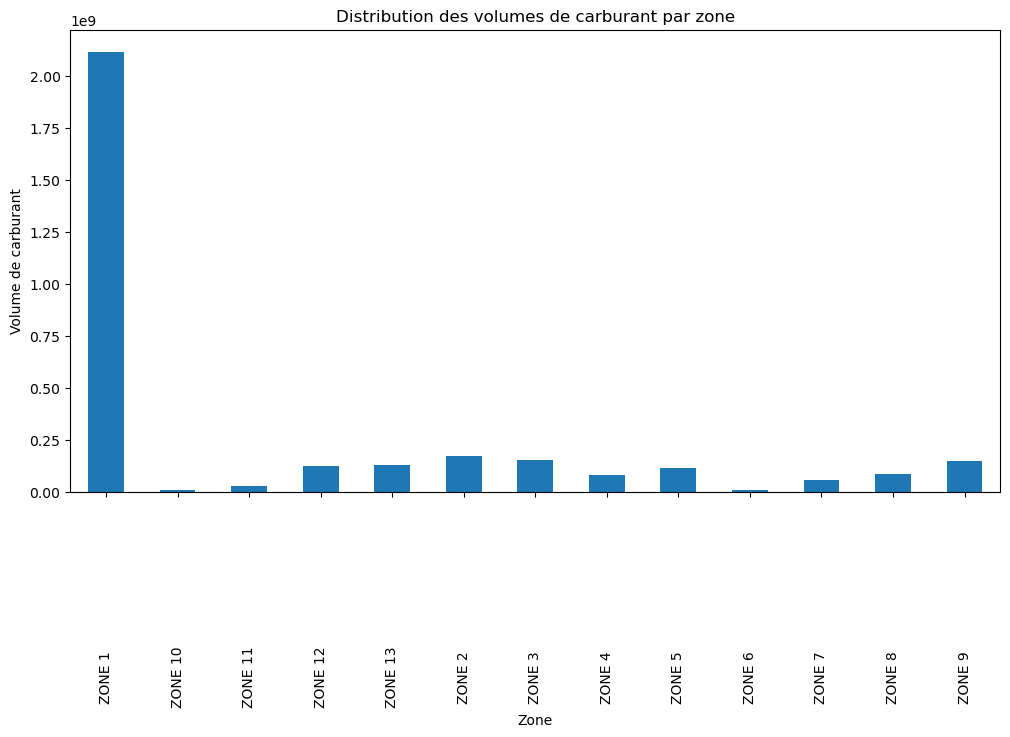

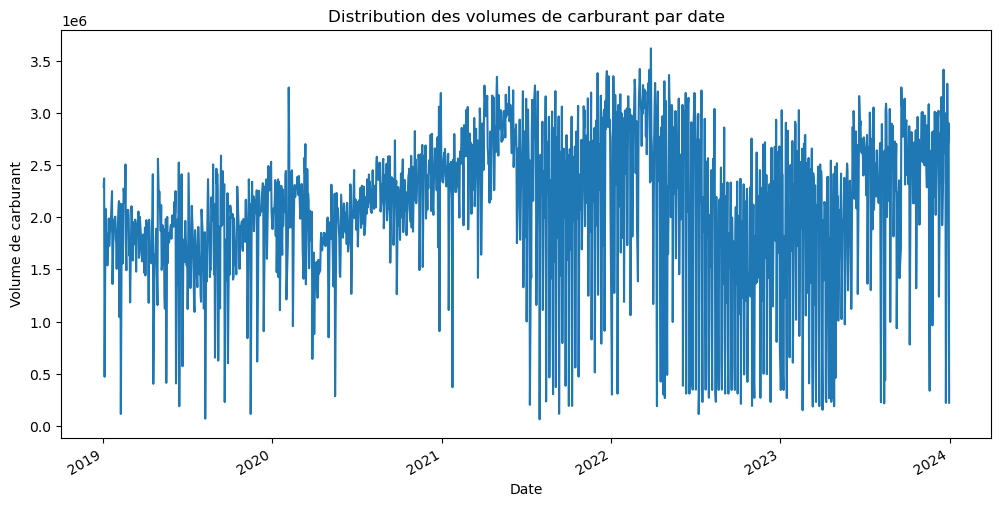

In [4]:
import matplotlib.pyplot as plt

# Exploration des données

# Visualisation de la distribution des volumes de carburant par zone
plt.figure(figsize=(12, 6))
data.groupby('ZONE')['VOLUME'].sum().plot(kind='bar')
plt.title('Distribution des volumes de carburant par zone')
plt.xlabel('Zone')
plt.ylabel('Volume de carburant')
plt.show()

# Visualisation de la distribution des volumes de carburant par date
plt.figure(figsize=(12, 6))
data.groupby('DATE')['VOLUME'].sum().plot()
plt.title('Distribution des volumes de carburant par date')
plt.xlabel('Date')
plt.ylabel('Volume de carburant')
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

# Séparation des données en ensembles d'entraînement et de test
X = data[['DATE', 'ZONE']]
y = data['VOLUME']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extraction des caractéristiques de la colonne DATE
X_train['YEAR'] = X_train['DATE'].dt.year
X_train['MONTH'] = X_train['DATE'].dt.month
X_train.drop(columns=['DATE'], inplace=True)

X_test['YEAR'] = X_test['DATE'].dt.year
X_test['MONTH'] = X_test['DATE'].dt.month
X_test.drop(columns=['DATE'], inplace=True)

# Conversion des variables catégorielles en variables indicatrices
X_train = pd.get_dummies(X_train, columns=['ZONE'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['ZONE'], drop_first=True)


# Affichage des tailles des ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement:", len(X_train))
print("Taille de l'ensemble de test:", len(X_test))


Taille de l'ensemble d'entraînement: 241113
Taille de l'ensemble de test: 60279


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Entraînement du modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation des performances du modèle
mse = mean_squared_error(y_test, y_pred)
print("Erreur quadratique moyenne (MSE) :", mse)


Erreur quadratique moyenne (MSE) : 86603043.9321223


## Essai des séries temporelles 

In [7]:
# Préparation des données pour les séries temporelles
time_series_data = data.groupby(['DATE', 'ZONE'])['VOLUME'].sum().reset_index()
time_series_data = time_series_data.set_index('DATE')


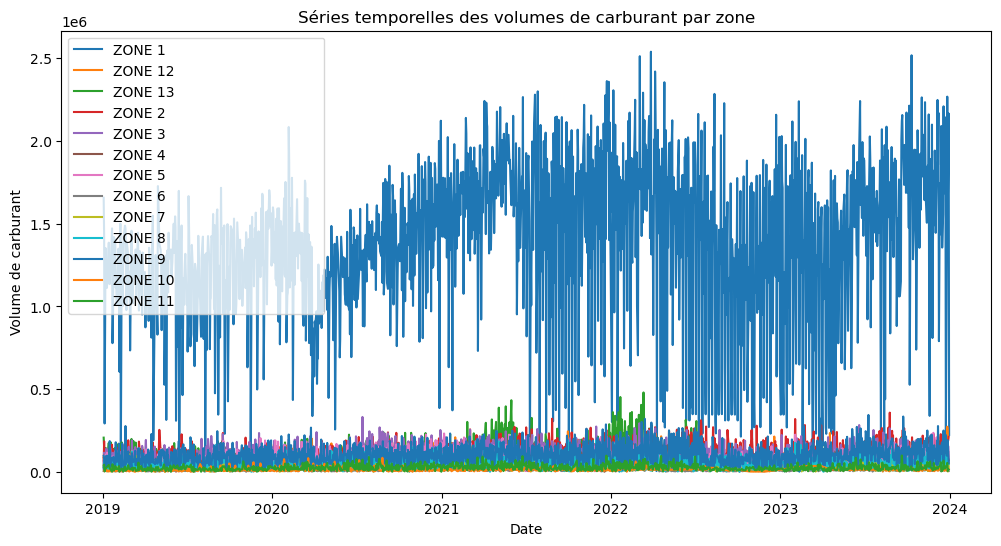

In [8]:
import matplotlib.pyplot as plt

# Visualisation des séries temporelles pour chaque zone
zones = time_series_data['ZONE'].unique()
plt.figure(figsize=(12, 6))
for zone in zones:
    zone_data = time_series_data[time_series_data['ZONE'] == zone]
    plt.plot(zone_data.index, zone_data['VOLUME'], label=zone)
plt.title('Séries temporelles des volumes de carburant par zone')
plt.xlabel('Date')
plt.ylabel('Volume de carburant')
plt.legend()
plt.show()


In [9]:
from statsmodels.tsa.stattools import adfuller

# Fonction pour effectuer le test de Dickey-Fuller augmenté (ADF)
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Vérification de la stationnarité pour chaque zone
for zone in zones:
    zone_data = time_series_data[time_series_data['ZONE'] == zone]['VOLUME']
    print(f"Zone {zone}:")
    adf_test(zone_data)
    print()


Zone ZONE 1                                  :
ADF Statistic: -2.796129659274312
p-value: 0.05882874901180837
Critical Values:
   1%: -3.434702484091523
   5%: -2.8634623461571733
   10%: -2.567793432853942

Zone ZONE 12                                 :
ADF Statistic: -2.9534356083207047
p-value: 0.039477720897639304
Critical Values:
   1%: -3.435094023613352
   5%: -2.863635138949194
   10%: -2.567885448250043

Zone ZONE 13                                 :
ADF Statistic: -3.181071450410056
p-value: 0.021106816163029566
Critical Values:
   1%: -3.4353516488758684
   5%: -2.8637488209107196
   10%: -2.5679459879960373

Zone ZONE 2                                  :
ADF Statistic: -3.4700256672017007
p-value: 0.008791106106523977
Critical Values:
   1%: -3.434966750462565
   5%: -2.8635789736973725
   10%: -2.5678555388041384

Zone ZONE 3                                  :
ADF Statistic: -4.13231255089027
p-value: 0.0008560332391707026
Critical Values:
   1%: -3.4349569928153607
   5%:

In [11]:
# Différenciation des séries temporelles pour rendre stationnaires
def difference_series(series):
    diff = series.diff().dropna()
    return diff

# Séries temporelles différenciées
differentiated_time_series = time_series_data.groupby('ZONE')['VOLUME'].apply(difference_series)

# Vérification de la stationnarité pour chaque série temporelle différenciée
for zone in zones:
    diff_zone_data = differentiated_time_series[zone]
    print(f"Zone {zone}:")
    adf_test(diff_zone_data)
    print()


Zone ZONE 1                                  :
ADF Statistic: -11.58881538823104
p-value: 2.8244495459700525e-21
Critical Values:
   1%: -3.4347141029098758
   5%: -2.8634674740559594
   10%: -2.5677961635037003

Zone ZONE 12                                 :
ADF Statistic: -13.937954734002433
p-value: 4.9514434652718255e-26
Critical Values:
   1%: -3.435094023613352
   5%: -2.863635138949194
   10%: -2.567885448250043

Zone ZONE 13                                 :
ADF Statistic: -17.200289651712897
p-value: 6.46631509490345e-30
Critical Values:
   1%: -3.4353516488758684
   5%: -2.8637488209107196
   10%: -2.5679459879960373

Zone ZONE 2                                  :
ADF Statistic: -12.817481692129714
p-value: 6.255239003772357e-24
Critical Values:
   1%: -3.434973278556316
   5%: -2.8635818545830376
   10%: -2.567857072940785

Zone ZONE 3                                  :
ADF Statistic: -12.749758996737429
p-value: 8.584958625736733e-24
Critical Values:
   1%: -3.4349831053858

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Identification des paramètres ARIMA optimaux pour chaque zone
arima_models = {}
for zone in zones:
    print(f"Zone {zone}:")
    model = auto_arima(differentiated_time_series[zone], seasonal=False, trace=True)
    arima_models[zone] = model

# Entraînement des modèles ARIMA pour chaque zone
trained_arima_models = {}
for zone, model in arima_models.items():
    trained_model = ARIMA(differentiated_time_series[zone], order=model.order)
    trained_arima_models[zone] = trained_model.fit()

# Affichage des modèles ARIMA entraînés pour chaque zone
for zone, model in trained_arima_models.items():
    print(f"Modèle ARIMA pour la zone {zone}:")
    print(model.summary())
    print()


Zone ZONE 1                                  :
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=43830.601, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44968.607, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=44555.366, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=43902.120, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=43860.146, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=43868.918, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=43815.277, Time=0.52 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=43870.911, Time=0.29 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=43805.141, Time=0.50 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=43856.128, Time=0.32 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=43683.651, Time=0.47 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=43714.867, Time=0.51 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=43671.901, Time=0.58 sec
 ARIMA(4,0,3)(0,0,0)[0]             : A

 ARIMA(4,0,2)(0,0,0)[0]             : AIC=34307.626, Time=0.88 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=34298.574, Time=0.71 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=34297.601, Time=1.48 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=34295.887, Time=1.06 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=34295.749, Time=0.42 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=34332.058, Time=0.48 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=34295.432, Time=0.61 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=34312.076, Time=0.56 sec
 ARIMA(3,0,5)(0,0,0)[0]             : AIC=34297.383, Time=1.55 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=34299.756, Time=0.73 sec

Best model:  ARIMA(2,0,5)(0,0,0)[0]          
Total fit time: 11.727 seconds
Zone ZONE 6                                  :
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13777.482, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14232.817, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]     

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Prog

Modèle ARIMA pour la zone ZONE 1                                  :
                               SARIMAX Results                                
Dep. Variable:                 VOLUME   No. Observations:                 1526
Model:                 ARIMA(5, 0, 5)   Log Likelihood              -21813.360
Date:                Tue, 14 May 2024   AIC                          43650.719
Time:                        11:00:13   BIC                          43714.684
Sample:                             0   HQIC                         43674.528
                               - 1526                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -939.0562    748.300     -1.255      0.210   -2405.698     527.586
ar.L1         -0.5283      0.053     -9.963      0.000      -0.

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Initialisation d'un dictionnaire pour stocker les modèles ARIMA pour chaque zone
arima_models = {}

# Entraînement des modèles ARIMA pour chaque zone
for zone in zones:
    print(f"Entraînement du modèle ARIMA pour la zone {zone}...")
    # Création du modèle ARIMA avec les paramètres optimaux identifiés
    model = ARIMA(differentiated_time_series[zone], order=(3, 0, 2))
    # Entraînement du modèle
    arima_model = model.fit()
    # Stockage du modèle dans le dictionnaire
    arima_models[zone] = arima_model

print("Entraînement des modèles ARIMA terminé.")


Entraînement du modèle ARIMA pour la zone ZONE 1                                  ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

Entraînement du modèle ARIMA pour la zone ZONE 12                                 ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Entraînement du modèle ARIMA pour la zone ZONE 13                                 ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Entraînement du modèle ARIMA pour la zone ZONE 2                                  ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Entraînement du modèle ARIMA pour la zone ZONE 3                                  ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Entraînement du modèle ARIMA pour la zone ZONE 4                                  ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Entraînement du modèle ARIMA pour la zone ZONE 5                                  ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Entraînement du modèle ARIMA pour la zone ZONE 6                                  ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

Entraînement du modèle ARIMA pour la zone ZONE 7                                  ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Entraînement du modèle ARIMA pour la zone ZONE 8                                  ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Entraînement du modèle ARIMA pour la zone ZONE 9                                  ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Entraînement du modèle ARIMA pour la zone ZONE 10                                 ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Entraînement du modèle ARIMA pour la zone ZONE 11                                 ...


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

Entraînement des modèles ARIMA terminé.


In [24]:
# Initialisation d'un dictionnaire pour stocker les prédictions pour chaque zone
predictions = {}

# Faire des prédictions pour chaque zone avec les modèles ARIMA entraînés
for zone, model in arima_models.items():
    print(f"Génération des prédictions pour la zone {zone}...")
    # Faire des prédictions pour les périodes futures
    forecast = model.predict(start=len(differentiated_time_series[zone]), end=len(differentiated_time_series[zone]) + 365)
    # Stocker les prédictions dans le dictionnaire
    predictions[zone] = forecast

print("Prédictions générées.")


Génération des prédictions pour la zone ZONE 1                                  ...
Génération des prédictions pour la zone ZONE 12                                 ...
Génération des prédictions pour la zone ZONE 13                                 ...
Génération des prédictions pour la zone ZONE 2                                  ...
Génération des prédictions pour la zone ZONE 3                                  ...
Génération des prédictions pour la zone ZONE 4                                  ...
Génération des prédictions pour la zone ZONE 5                                  ...
Génération des prédictions pour la zone ZONE 6                                  ...
Génération des prédictions pour la zone ZONE 7                                  ...
Génération des prédictions pour la zone ZONE 8                                  ...
Génération des prédictions pour la zone ZONE 9                                  ...
Génération des prédictions pour la zone ZONE 10                             

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\lib\site-packages\statsmode

In [25]:
import pandas as pd

# Initialisation d'un DataFrame pour stocker les prédictions pour chaque zone
predictions_df = pd.DataFrame()

# Ajout des dates pour les 5 prochaines périodes
future_dates = pd.date_range(start=data['DATE'].max() + pd.Timedelta(days=1), periods=365)

# Pour chaque zone, ajoutez les prédictions au DataFrame avec les dates correspondantes
for zone, forecast in predictions.items():
    # Création d'un DataFrame temporaire pour stocker les prédictions de cette zone
    zone_forecast_df = pd.DataFrame({zone: forecast}, index=future_dates)
    # Ajout des prédictions de cette zone au DataFrame global
    predictions_df = pd.concat([predictions_df, zone_forecast_df], axis=1)

# Visualisation des prédictions
print(predictions_df)


            ZONE 1                                    \
2024-01-01                                       NaN   
2024-01-02                                       NaN   
2024-01-03                                       NaN   
2024-01-04                                       NaN   
2024-01-05                                       NaN   
...                                              ...   
2024-12-26                                       NaN   
2024-12-27                                       NaN   
2024-12-28                                       NaN   
2024-12-29                                       NaN   
2024-12-30                                       NaN   

            ZONE 12                                   \
2024-01-01                                       NaN   
2024-01-02                                       NaN   
2024-01-03                                       NaN   
2024-01-04                                       NaN   
2024-01-05                                     

In [28]:
import pandas as pd

# Création d'un DataFrame pour stocker les prédictions
predictions_df = pd.DataFrame(predictions)

# Ajout des dates pour les 5 prochaines périodes
future_dates = pd.date_range(start=data['DATE'].max() + pd.Timedelta(days=1), periods=1263)
predictions_df.index = future_dates

# Visualisation des prédictions
print(predictions_df)


            ZONE 1                                    \
2024-01-01                                       NaN   
2024-01-02                                       NaN   
2024-01-03                                       NaN   
2024-01-04                                       NaN   
2024-01-05                                       NaN   
...                                              ...   
2027-06-12                               -939.055092   
2027-06-13                               -939.054991   
2027-06-14                               -939.055086   
2027-06-15                               -939.054996   
2027-06-16                               -939.055081   

            ZONE 12                                   \
2024-01-01                                       NaN   
2024-01-02                                       NaN   
2024-01-03                                       NaN   
2024-01-04                                       NaN   
2024-01-05                                     

In [29]:
print("Nombre de lignes dans predictions_df:", len(predictions_df))
print("Nombre d'éléments dans future_dates:", len(future_dates))


Nombre de lignes dans predictions_df: 1263
Nombre d'éléments dans future_dates: 1263


## Random forest